<a href="https://colab.research.google.com/github/Astra42/ImageComparison/blob/main/img_comrasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ссылка для скачивания изображений <br>
https://drive.google.com/drive/folders/1UegUUEhFTKfUJQ6IxJVkgFD6ifilc6NE?usp=sharing

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from scipy import stats

Очень важно, чтобы все внутри изображения было в рамке, она может быть не целой, а только нижняя, правая и левая части, причем правая и левая могут быть прозрачными, а вот нижняя обязательно должна быть видна

In [73]:
# функция, делающая поворот так, чтобы картинка на обрезалась
# x и y -параметры сдвига, но по дефолту изображения всегда будет сдвигаться, чтобы не было обрезаний
# так что сдвиги лучше не пытаться задавать
# dop если задать 1, будет корректно обрабатывать большие сдвиги, не обрезая изображений
def rotate_and_moove(img, alpha, x, y, dop=0):
  alpha = alpha*np.pi/180
  h,w = img.shape
  w_padding = int(abs(h*np.sin(alpha)))
  h_padding = int(abs(w*np.sin(alpha)))
  x = w_padding if x<w_padding else x
  x = 0 if alpha>0 else x
  y = h_padding if y<h_padding else y
  y = 0 if alpha<0 else y
  afine_matrix = np.float32([[np.cos(alpha), np.sin(alpha), x], 
                             [-np.sin(alpha),  np.cos(alpha), y]])
  res = cv2.warpAffine(img, afine_matrix, (w+w_padding+dop*x,h+h_padding+dop*y), borderValue=255)
  return res

# предобработка изображений
# separator - разделительная черта между "черными" и "белыми" пикселями
# resize_k - коэф сжатия/расширения изображений
# pad - отступ со всех сторон для
def preprocess(img_p, separator=220, resize_k=1, pad = 0):
  img = cv2.imread(img_p)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  bin = np.vectorize(lambda x: 0 if x<separator else 255)
  img = bin(img).astype('uint8')
  if resize_k!=1:
    h,w = img.shape
    img = cv2.resize(img,(int(resize_k*w), int(resize_k*h)))
  if pad>0:
    img = img[pad:-pad,pad:-pad]
  return img

# ищет точки на нижней части рамки
def find_points(img):
  h,w = img.shape
  p1 = ()
  p2 = ()
  eye = 1
  black = 0
  for i, row in enumerate(img[::-1]):
    if black in row:
      ind = np.where(row==black)
      min_ind = ind[0][0]
      max_ind = ind[0][-1]
      p1 = (max_ind if min_ind>w/2 else min_ind, h-i-1) 
      eye = 1 if min_ind>w/2 else -1
      break

  for i, column in enumerate(img.T[::eye]):
    if black in column:
      ind = np.where(column==black)[0][-1]
      x = i if eye>0 else w-1-i
      p2 = (x, ind)  
      break

  return [p1, p2]

# попиксельное сравнение изображений с возможностью применить медианный фильтр
# treshold - допустимая разница между двумя пикселями
def binary_masks(i1, i2, use_m_filt=True, kernel_size=3, treshold=5):
  img = i1-i2
  if use_m_filt:
    #median_filter(img,kernel_size)
    img = cv2.medianBlur(img, kernel_size)
  similarity = np.vectorize(lambda x:True if x<=treshold else False)(img).astype('uint8')
  difference = np.vectorize(lambda x:True if x> treshold else False)(img).astype('uint8')
  return similarity, difference

# попиксельное сравнение изображений с использованием рамки
# если пиксель точки i1,j1 содержится в рамке с центром i2,j2 и стороной=k, то считается, что пиксели совпадают
def binary_masks_with_kernel(i1,i2,k=3):
  h,w = i1.shape
  res = np.zeros((h,w))
  for i in range(k, h-k):
    for j in range(k, w-k):
      res[i,j] = i2[i,j] in i1[i-k:i+k+1,j-k:j+k+1]

  similarity = cv2.medianBlur(res.astype('uint8'), 3)
  difference = np.vectorize(lambda x: False if x else True)(similarity).astype('uint8')
  return similarity, difference

# метод сдвигающий одно нормальное(с убранным поворотом) изображение к другому нормальному
# возвращает матрицу афинного преобразования 2го в 1ое и то, на сколько надо сдвинуть 2ое, чтобы получить 1ое
def without_rot(img1, img2):
  h,w = img1.shape
  cord1 = np.array([[(j,i) for j in range(w)] for i in range(h)])
  h,w = img2.shape
  cord2 = np.array([[(j,i) for j in range(w)] for i in range(h)])

  black1 = cord1[img1<220]
  black2 = cord2[img2<220]

  max_w1 = np.float32(max(black1, key = lambda x: x[0]))[0]
  max_h1 = np.float32(max(black1, key = lambda x: x[1]))[1]
  max_w2 = np.float32(max(black2, key = lambda x: x[0]))[0]
  max_h2 = np.float32(max(black2, key = lambda x: x[1]))[1]

  dx = -max_w2+max_w1
  dy = -max_h2+max_h1
  return np.array([[1,0,dx],
                   [0,1,dy]]), (dx,dy)

# метод, убирающий поворот у изображения  
# возвращает нормальное изображение и угол поворота
def reverse_rot(img):
  corners = find_points(img)
  p1 = corners[0]
  p2 = corners[1]
  tg = (p1[1]-p2[1])/(p1[0]-p2[0])
  alpha = np.arctan(tg)
  alpha = alpha*180/np.pi
  #print(alpha)
  rot_img = rotate_and_moove(img, alpha, 0, 0)
  return rot_img, alpha

# объединение некоторох из методов выше
# use_d_and_e используется для расширения/сжатия элементов изображения
# такой подход (сначала расширили потом сжали) позволяет сравнивать расширенные изображения,
# убирая неточности обратных поворотов, а затем, сужая, возвращать к почти прежнему состоянию + удалять шумы
# kernels - размеры фильтров для расширения(dilate) и сужения(erode)
def image_comparison(img1, img2, comp_func, comp_func_params,
                     separator = 220, use_d_and_e = True, kernels=[3,2]):
  k1, k2 = kernels
  r_i1, a1 = reverse_rot(img1)
  r_i2, a2 = reverse_rot(img2)

  bin = np.vectorize(lambda x: 0 if x>separator else 255)
  if use_d_and_e:
    r_i1 = bin(r_i1).astype('uint8')
    r_i2 = bin(r_i2).astype('uint8')

    kernel1 = np.ones((k1, k1), 'uint8')
    r_i1 = cv2.dilate(r_i1, kernel1, iterations=2)
    r_i2 = cv2.dilate(r_i2, kernel1, iterations=2)

    r_i1 = bin(r_i1).astype('uint8')
    r_i2 = bin(r_i2).astype('uint8')

  M, shift = without_rot(r_i1,r_i2)
  h,w = r_i1.shape
  conv_i2 = cv2.warpAffine(r_i2, M, (w,h),borderValue=255)

  s, d = comp_func(r_i1, conv_i2, *comp_func_params)
  if use_d_and_e:
    kernel2 = np.ones((k2, k2), 'uint8')
    s = cv2.erode(s, kernel2, iterations=1)
  
  return s, d, [a1, a2], shift


# обертка для решения, можно создать класс, поменять нужные поля, а затем сделать сравнение изображений с новыми полями
class Сomparer:
  def __init__(self, path1, path2):
    self.path1 = path1
    self.path2 = path2
    self.separator = 220  # разделительная черта между "черными" и "белыми" пикселями
    self.resize_k1 = 1  # коэф сжатия/расширения 1го изображений
    self.resize_k2 = 1  # 2го изображения
    self.pad1 = 0  # отступ со всех сторон для 1го изображений
    self.pad2 = 0  # 2го изображения
    self.all_compr_funcs = {"non_k":binary_masks, "k":binary_masks_with_kernel}  # функции сравнения изображений, приведенных к норм виду
    self.compr_funcs_default_params = {"non_k":(True, 3, 5), "k":(3)}  # их дефолтные параметры
    self.func = "non_k"  # используемая функция
    self.use_d_and_e = True  # условие использования dilate и erode
    self.d_and_e_kernels = [3,2]  # размеры их кернелов

# возвращает маску сходств, маску различий, метрику сходства (где 1 идентичны, 0 абсолютно разные),
# углы изображений, и сдвиг 2го нормального изображения относительно 1го(тоже нормального)
  def init_compraision(self):
    img1 = preprocess(self.path1, self.separator, self.resize_k1, self.pad1)
    img2 = preprocess(self.path2, self.separator, self.resize_k2, self.pad2)

    s,d,alphas,shift = image_comparison(img1, img2, self.all_compr_funcs[self.func], self.compr_funcs_default_params[self.func],
                           self.separator, self.use_d_and_e, self.d_and_e_kernels)
    
    h,w = s.shape
    sim_metric = s.sum().sum()/h/w

    return s,d,sim_metric,alphas,shift

Пример использования

(0.9948709807656878, [-13.989906414128154, 14.986834894936488], (-23.0, -14.0))

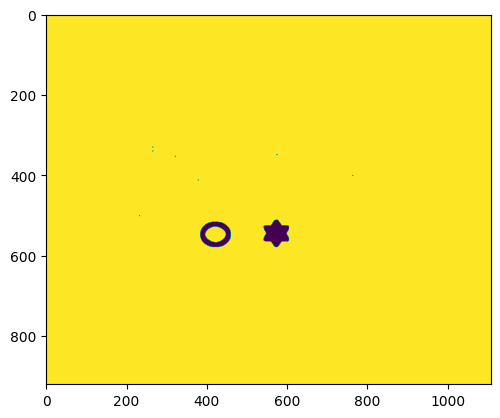

In [76]:
path1 = "/content/Untitled1.png"
path2 = "/content/Untitled2.png"

c = Сomparer(path1, path2)
c.pad1=2
c.pad2=2

s,d,m,a,sh = c.init_compraision()
plt.imshow(s)
m, a, sh

Ничего важного

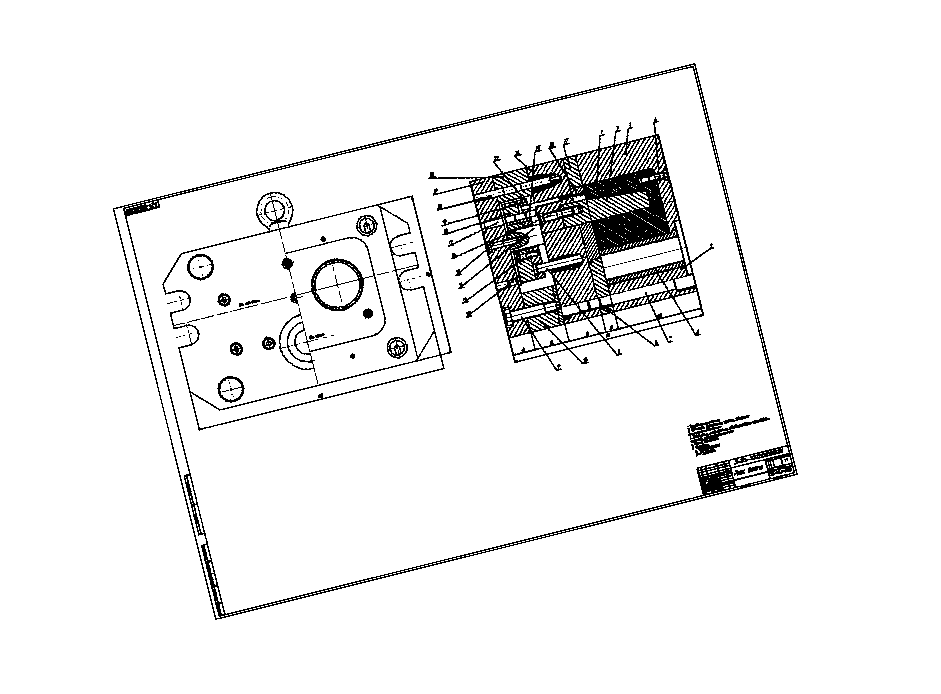

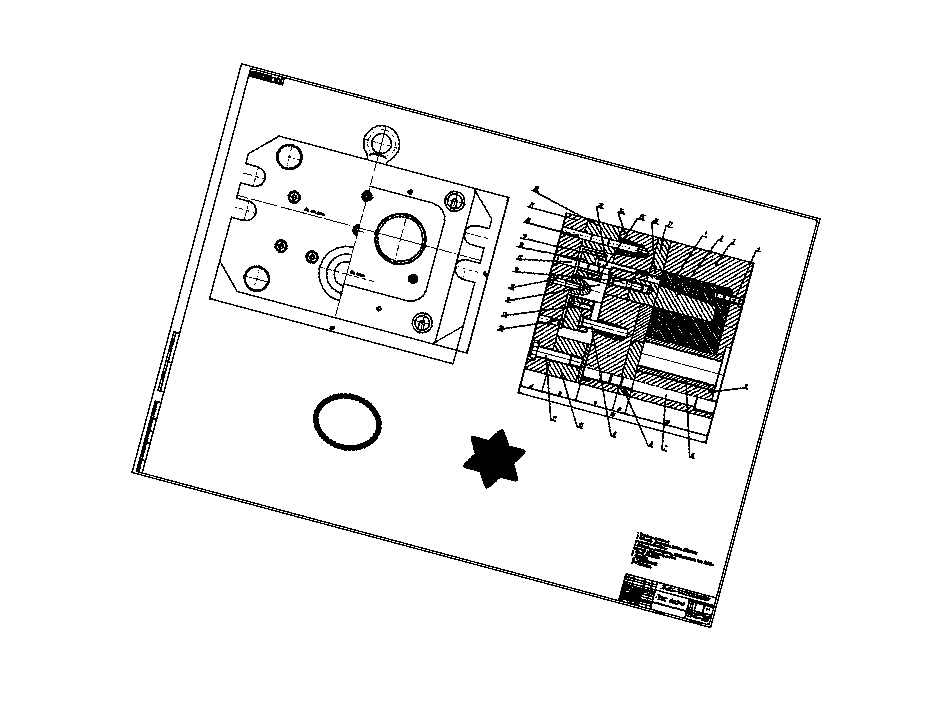

(0.9948709807656878, [-13.989906414128154, 14.986834894936488])

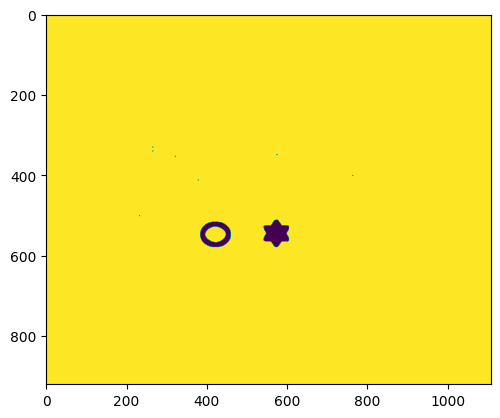

In [78]:
path1 = "/content/Untitled1.png"
path2 = "/content/Untitled2.png"
img1 = preprocess(path1, pad=2)
img2 = preprocess(path2, pad=2)
i1 = rotate_and_moove(img1, 0, 0, 0)
i2 = rotate_and_moove(img2, 0, 0, 0)
cv2_imshow(i1)
cv2_imshow(i2)

s,d,a,sh = image_comparison(i1, i2, binary_masks, (True, 3, 5))
h,w = s.shape

import matplotlib.pyplot as plt
plt.imshow(s)
s.sum().sum()/h/w, a

In [ ]:
ps

[(593, 450), (1, 419)]

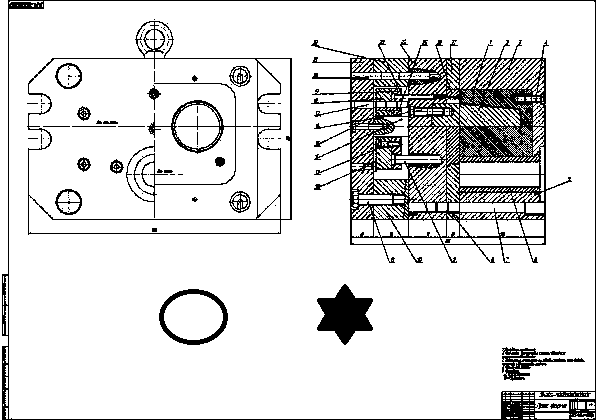

-5.124492073975319


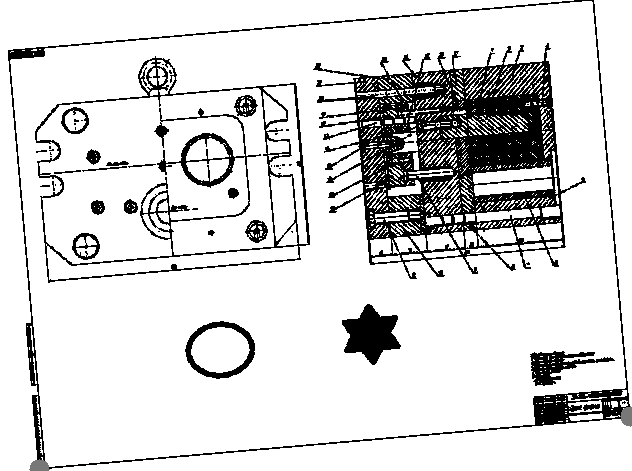

In [ ]:
path1 = "/content/big with dif.png"
img1 = preprocess(path1, pad=2)
cv2_imshow(img1)
#cv2_imshow(img1)
i1 = rotate_and_moove(img1, 5, 0, 0)
bin = np.vectorize(lambda x: 0 if x<220 else 255)
i1 = bin(i1).astype('uint8')

ps = find_points(i1)
p1 = ps[0]
p2 = ps[1]
tg = (p1[1]-p2[1])/(p1[0]-p2[0])
alpha = np.arctan(tg)
alpha = alpha*180/np.pi
print(alpha)
def draw_p(im, points):
  i = im.copy()
  for p in points:
    cv2.circle(i,(int(p[0]), int(p[1])), 10,(120,120,120), -1) 
  return i

cv2_imshow(draw_p(i1, ps))